<a href="https://colab.research.google.com/github/thasliya0404/projetict/blob/main/Block_wise_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/cleaned_data.csv")

In [ ]:
df.columns

Index(['Year', 'Crop', 'District', 'Block_name', 'grand_total_production',
       'grand_total_area', 'Rain_fall_actual(mm)', 'Rain_fall_deviation(%)',
       'Temp_max(C)', 'Temp_min(C)', 'Yield', 'Temp_mean(C)', 'Tbase',
       'GDD_Year'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Encode categorical features
block_encoder = LabelEncoder()
crop_encoder = LabelEncoder()

df['Block_ID'] = block_encoder.fit_transform(df['Block_name'])
df['Crop_ID'] = crop_encoder.fit_transform(df['Crop'])


In [ ]:
# Sort properly
df = df.sort_values(['Crop_ID', 'Block_ID', 'Year']).reset_index(drop=True)

In [ ]:
seq_length = 5
X, y = [],[]

for crop in df['Crop_ID'].unique():
    for block in df['Block_ID'].unique():
        subset = df[(df['Crop_ID'] == crop) & (df['Block_ID'] == block)].sort_values('Year')
        if len(subset) > seq_length:
            values = subset[['Crop_ID', 'Block_ID', 'GDD_Year','Temp_mean(C)',
                              'Rain_fall_actual(mm)', 'grand_total_production', 'grand_total_area', 'Yield']].values
            for i in range(len(values) - seq_length):
                X.append(values[i:i+seq_length])
                y.append(values[i+seq_length][-1])  # next year's yield

X, y = np.array(X), np.array(y)

In [ ]:
years = sorted(df['Year'].unique())
train_years = years[:-1]
test_years = years[-1:]

# Find indices for training/testing
train_idx = [i for i in range(len(X)) if np.all(X[i][:, 1]) and df['Year'].iloc[i+seq_length-1] in train_years]
test_idx  = [i for i in range(len(X)) if np.all(X[i][:, 1]) and df['Year'].iloc[i+seq_length-1] in test_years]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [ ]:
scaler = MinMaxScaler()
X_train_scaled, X_test_scaled = X_train.copy(), X_test.copy()

X_train_scaled[:, :, 2:] = scaler.fit_transform(
    X_train[:, :, 2:].reshape(-1, X_train.shape[2]-2)
).reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2]-2)

X_test_scaled[:, :, 2:] = scaler.transform(
    X_test[:, :, 2:].reshape(-1, X_test.shape[2]-2)
).reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2]-2)

In [ ]:
crop_train = X_train_scaled[:, :, 0].astype(int)
block_train = X_train_scaled[:, :, 1].astype(int)
num_train = X_train_scaled[:, :, 2:]

crop_test = X_test_scaled[:, :, 0].astype(int)
block_test = X_test_scaled[:, :, 1].astype(int)
num_test = X_test_scaled[:, :, 2:]

In [ ]:
n_crops = len(df['Crop_ID'].unique())
n_blocks = len(df['Block_ID'].unique())
n_features = X.shape[2]
embedding_dim = 8

In [ ]:
crop_input = Input(shape=(X.shape[1],), dtype='int32', name='crop_input')
block_input = Input(shape=(X.shape[1],), dtype='int32', name='block_input')
numeric_input = Input(shape=(X.shape[1], n_features-2), name='numeric_input')

In [ ]:
crop_embed = Embedding(input_dim=n_crops, output_dim=embedding_dim)(crop_input)
block_embed = Embedding(input_dim=n_blocks, output_dim=embedding_dim)(block_input)

In [ ]:
# Combine embeddings + numeric
x = Concatenate(axis=-1)([crop_embed, block_embed, numeric_input])

In [ ]:
# LSTM + Dense Layers
x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='linear')(x)

In [ ]:
# Model definition
model = Model(inputs=[crop_input, block_input, numeric_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ crop_input          │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_input         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 5, 8)      │         32 │ crop_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 5, 8)      │      1,216 │ block_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 5, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5, 22)     │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ embedding_1[0][0… │
│                     │                   │            │ numeric_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     22,272 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,633 (100.13 KB)

 Trainable params: 25,633 (100.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    [crop_train, block_train, num_train],
    y_train,
    validation_data=([crop_test, block_test, num_test], y_test),
    epochs=50,
    batch_size=16,
    verbose=1
)


Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 358.1323 - mae: 10.9941 - val_loss: 42.3353 - val_mae: 3.6891
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 44.1623 - mae: 3.5937 - val_loss: 38.8353 - val_mae: 3.1690
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 40.7470 - mae: 3.2979 - val_loss: 28.0006 - val_mae: 2.8263
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 32.2722 - mae: 2.9390 - val_loss: 22.4339 - val_mae: 2.4931
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 25.4122 - mae: 2.6611 - val_loss: 22.5710 - val_mae: 2.5356
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 22.1355 - mae: 2.4171 - val_loss: 23.5671 - val_mae: 2.5572
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.9167 - mae: 2.1749 - val_loss: 27.1803 - val_mae: 2.8202
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 19.7052 - mae: 2.4629 - val_loss: 22.6217 - val_mae: 2.5282
Epoch 9/50
135/135 ━━━━━━━━━━━━━━━━━━━

In [ ]:
loss, mae = model.evaluate([crop_test, block_test, num_test], y_test)
print(f"\n🌾 Test MAE: {mae:.4f}")

y_pred = model.predict([crop_test, block_test, num_test])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4042 - mae: 1.5599 

🌾 Test MAE: 2.3602
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


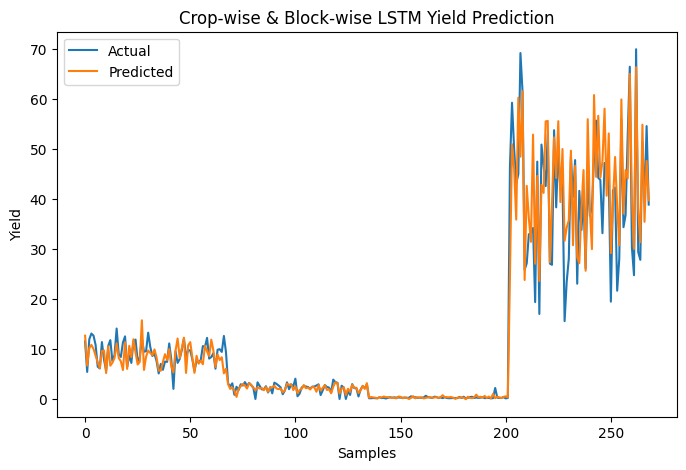

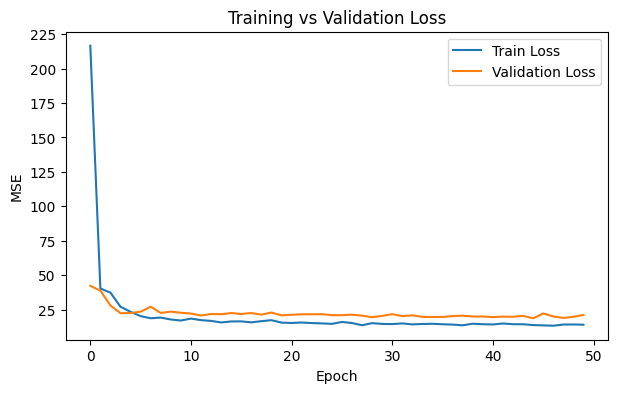

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Crop-wise & Block-wise LSTM Yield Prediction')
plt.xlabel('Samples')
plt.ylabel('Yield')
plt.legend()
plt.show()

# Training loss visualization
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  2.3602
MSE:  21.1380
RMSE: 4.5976
R²:   0.9294


In [ ]:
df['Crop'].unique()

array(['Banana', 'Paddy', 'Pepper', 'Tapioca'], dtype=object)

Predicting 2025 crop yield

In [ ]:
crop_name = "Tapioca"
block_name = "Aryad"
df_crop = df[(df['Crop'] == crop_name) &
                         (df['Block_name'] == block_name)].sort_values('Year')

In [ ]:
last_5_years = df_crop.tail(5)

In [ ]:
last_5_years.shape

(5, 16)

In [ ]:
X_input = last_5_years[['Crop_ID', 'Block_ID', 'GDD_Year','Temp_mean(C)',
                              'Rain_fall_actual(mm)', 'grand_total_production', 'grand_total_area', 'Yield']].values
X_input = np.expand_dims(X_input, axis=0)  # shape (1, 5, features)

In [ ]:
X_input.shape

(1, 5, 8)

In [ ]:
X_input_scaled = X_input.copy()

# Only attempt to scale if X_input is not empty (i.e., has timesteps)
if X_input.shape[1] > 0:
    # Scale only numeric features (skip Block_ID and Crop_ID)
    X_input_scaled[:, :, 2:] = scaler.transform(
        X_input[:, :, 2:].reshape(-1, X_input.shape[2]-2)
    ).reshape(X_input.shape[0], X_input.shape[1], X_input.shape[2]-2)
else:
    print(f"Warning: Input data for scaling is empty for Crop '{crop_name}' and Block '{block_name}'. Prediction will not proceed.")


In [ ]:
block_input_pred = X_input_scaled[:, :, 0].astype(int)
crop_input_pred = X_input_scaled[:, :, 1].astype(int)
num_input_pred = X_input_scaled[:, :, 2:]

In [ ]:
if X_input_scaled.shape[1] > 0:
    y_pred_2025 = model.predict([block_input_pred, crop_input_pred, num_input_pred])
    print(f"Predicted 2025 Yield for {crop_name} in {block_name}: {y_pred_2025[0][0]:.2f}")
else:
    print(f"Cannot predict for {crop_name} in {block_name} as historical data is insufficient or missing.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted 2025 Yield for Tapioca in Aryad: 35.67


2024 prediction

In [ ]:
crop_name = "Pepper"
block_name = "Kozhikode"

# Filter and sort by year
df_crop = df[(df['Crop'] == crop_name) &
             (df['Block_name'] == block_name)].sort_values('Year')

# Select years 2019–2023 (i.e., the last 5 years before 2024)
last_5_years = df_crop[df_crop['Year'].between(2019, 2023)]

In [ ]:
last_5_years.shape

(5, 16)

In [ ]:
X_input = last_5_years[['Crop_ID', 'Block_ID', 'GDD_Year','Temp_mean(C)',
                              'Rain_fall_actual(mm)', 'grand_total_production', 'grand_total_area', 'Yield']].values
X_input = np.expand_dims(X_input, axis=0)  # shape (1, 5, features)

In [ ]:
X_input.shape

(1, 5, 8)

In [ ]:
X_input_scaled = X_input.copy()

# Only attempt to scale if X_input is not empty (i.e., has timesteps)
if X_input.shape[1] > 0:
    # Scale only numeric features (skip Block_ID and Crop_ID)
    X_input_scaled[:, :, 2:] = scaler.transform(
        X_input[:, :, 2:].reshape(-1, X_input.shape[2]-2)
    ).reshape(X_input.shape[0], X_input.shape[1], X_input.shape[2]-2)
else:
    print(f"Warning: Input data for scaling is empty for Crop '{crop_name}' and Block '{block_name}'. Prediction will not proceed.")


In [ ]:
block_input_pred = X_input_scaled[:, :, 0].astype(int)
crop_input_pred = X_input_scaled[:, :, 1].astype(int)
num_input_pred = X_input_scaled[:, :, 2:]

In [ ]:
if X_input_scaled.shape[1] > 0:
    y_pred_2025 = model.predict([block_input_pred, crop_input_pred, num_input_pred])
    print(f"Predicted 2025 Yield for {crop_name} in {block_name}: {y_pred_2025[0][0]:.2f}")
else:
    print(f"Cannot predict for {crop_name} in {block_name} as historical data is insufficient or missing.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted 2025 Yield for Pepper in Kozhikode: 0.14


In [ ]:
print(df.loc[(df['Block_name'] == 'Kozhikode') & (df['Crop'] == 'Pepper') & (df['Year'] == 2024), 'Yield'])

3284    0.223103
Name: Yield, dtype: float64


save model

In [ ]:
model.save("lstm_crop_yield_model.h5")

In [ ]:
import joblib
joblib.dump(scaler, "scaler.pkl")
print("✅ Scaler saved as scaler.pkl")

✅ Scaler saved as scaler.pkl


In [ ]:
encoders = {
    "block_encoder": block_encoder,
    "crop_encoder": crop_encoder
}
joblib.dump(encoders, "encoders.pkl")
print("✅ Encoders saved as encoders.pkl")

✅ Encoders saved as encoders.pkl


In [ ]:
features_used = ['Crop_ID', 'Block_ID', 'GDD_Year','Temp_mean(C)',
                              'Rain_fall_actual(mm)', 'grand_total_production', 'grand_total_area', 'Yield']
joblib.dump(features_used, "features.pkl")
print("✅ Features list saved as features.pkl")

✅ Features list saved as features.pkl


In [ ]:
import json

config = {
    "sequence_length": 5,
    "target_column": "Yield",
    "year_column": "Year"
}
with open("config.json", "w") as f:
    json.dump(config, f, indent=4)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError

model_check = load_model(
    "lstm_crop_yield_model.h5",
    custom_objects={'mse': MeanSquaredError(), 'mae': MeanAbsoluteError()}
)
scaler_check = joblib.load("scaler.pkl")
encoders_check = joblib.load("encoders.pkl")
features_check = joblib.load("features.pkl")

print("\n✅ Verification successful!")
print("Saved features:", features_check)
print("Encoders:", list(encoders_check.keys()))


✅ Verification successful!
Saved features: ['Crop_ID', 'Block_ID', 'GDD_Year', 'Temp_mean(C)', 'Rain_fall_actual(mm)', 'grand_total_production', 'grand_total_area', 'Yield']
Encoders: ['block_encoder', 'crop_encoder']
